In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import warnings
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
#Some functions
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse_cal(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def evaluate_es_model_mape(X,Trend, Seasonal,m,damped=True):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    mape=(np.abs(np.array(test)-np.array(predictions))/np.array(test)).mean()
    return mape

In [3]:
zillow_test=pd.read_csv('/work/test.csv',parse_dates=['Month'])
zillow_test=zillow_test.set_index('Month')
zillow_test.head()

,Median House Price
Month,
2016-01-31,476250
2016-02-29,466000
2016-03-31,485000
2016-04-30,501000
2016-05-31,501000


In [4]:
zillow=pd.read_csv('/work/zillow-carlifornia.csv',parse_dates=['Date'])
zillow.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [5]:
zillow = zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})

In [6]:
zillow.head()

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [7]:
#Split dataset into 80/20
end_date = '2014-05-31'
end_date2 = '2015-12-31'
history = zillow.loc[(zillow['Date'] <= end_date)]
val = zillow.loc[(zillow['Date'] > end_date) & (zillow['Date'] <= end_date2)]

In [8]:
X=np.array(history['MedianSoldPrice'])
mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=12,damped=True)
mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=12,damped=True)
mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=12,damped=True)
mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=12,damped=True)

In [9]:
mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=12,damped=False)
mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=12,damped=False)

In [10]:
print(mape_1)
print(mape_2)
print(mape_3)
print(mape_4)
print(mape_5)
print(mape_6)

0.03786996933171643
0.031688567227485746
0.03677683551016181
4.984620329298538e+44
0.034217492594931564
0.041926780374377005


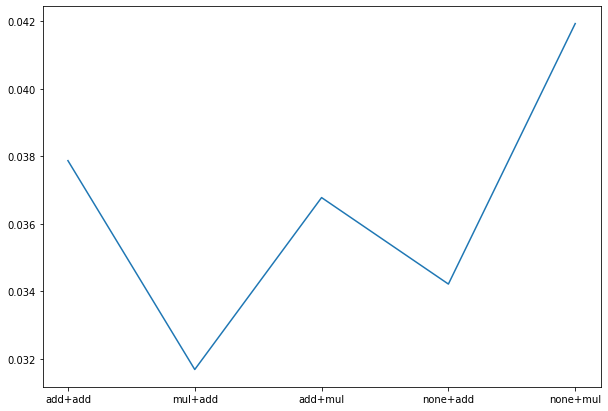

In [11]:
data = {'add+add': mape_1, 'mul+add': mape_2, 'add+mul': mape_3, 'none+add':mape_5, 'none+mul':mape_6}
models = list(data.keys())
rmse = list(data.values())
plt.figure(figsize=(10, 7))
plt.plot(models, rmse)

In [12]:
model_ets=ExponentialSmoothing(history["MedianSoldPrice"], trend="multiplicative", seasonal="additive", damped=True, seasonal_periods=12)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(val))
pred_ets.index=val.index

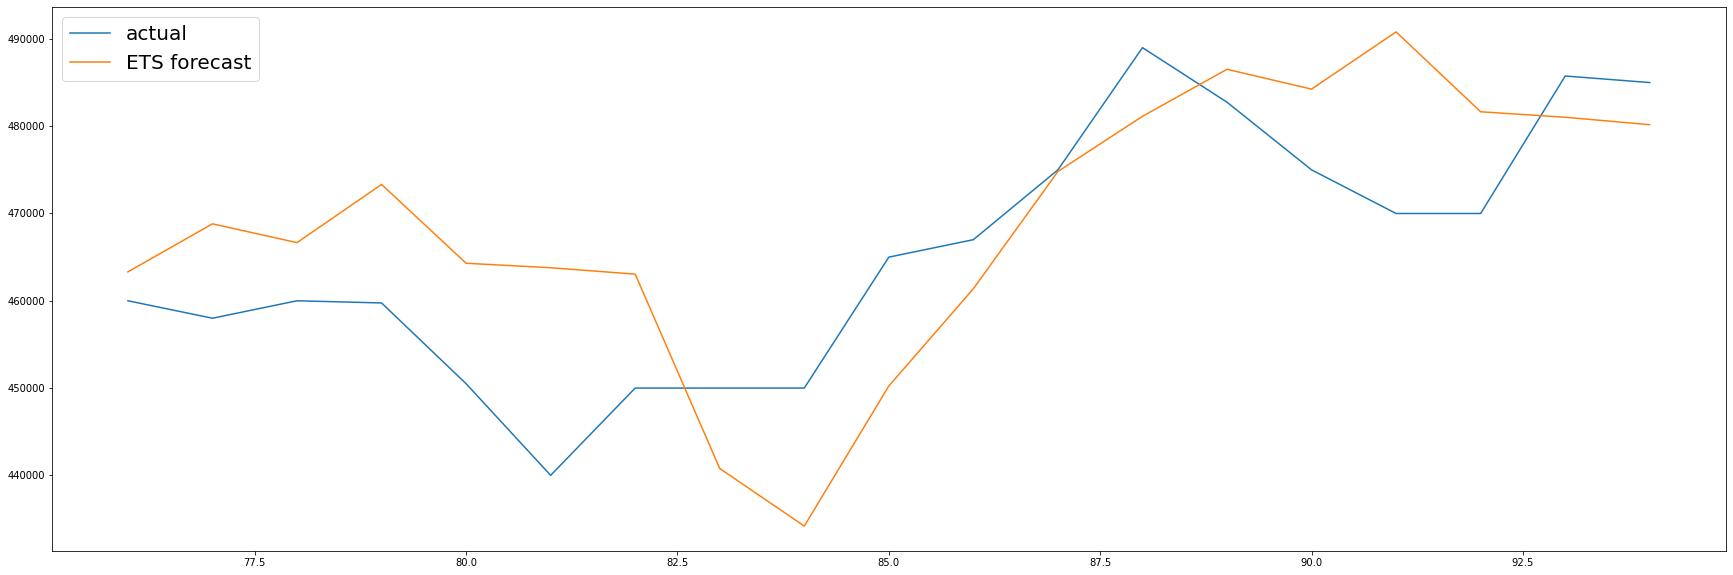

In [13]:
plt.figure(figsize=(30, 10))
plt.plot(val.MedianSoldPrice, label='actual')
plt.plot(pred_ets, label='ETS forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()


In [15]:
mape_val=(np.abs(np.array(val.MedianSoldPrice)-np.array(pred_ets))/np.array(val.MedianSoldPrice)).mean()
print(f"MAPE of ETS: {mape_val}")

MAPE of ETS: 0.02212690752728262


In [16]:
rmse1 = rmse_cal(np.array(val.MedianSoldPrice), np.array(pred_ets))
print(f"RMSE of ETS: {rmse1}")


RMSE of ETS: 11795.340106761016


In [17]:
#predicted values
pred_ets

76    463311.741161
77    468814.350492
78    466660.720545
79    473330.352103
80    464298.589138
81    463785.099244
82    463050.962758
83    440786.966522
84    434186.706452
85    450238.078596
86    461377.504982
87    474813.136951
88    481133.216863
89    486519.134403
90    484248.964741
91    490802.221816
92    481654.262472
93    481024.766893
94    480174.827722
dtype: float64

**Multivariate**

In [18]:
#sarimax 
zillow=pd.read_csv('zillow-carlifornia.csv',header=0, index_col="Date", parse_dates=True, squeeze=True)
zillow = zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
dt=zillow[['MedianMortageRate','UnemploymentRate','MedianSoldPrice']]

#train and val
period=12
train=dt[dt.index<='2014-05-31']
val=dt[dt.index >'2014-05-31']
val=val[val.index<='2015-12-31']

#scale data
dt=dt.dropna()
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
val_sc = sc.transform(val)

In [19]:
#auto sarimax search with m=12
from pmdarima.arima import auto_arima
model=auto_arima(train_sc[:,-1], 
                 exogenous= train_sc[:,:-1], 
                 start_p=0, start_q=0, 
                 max_p=4, max_q=4, 
                 max_d=2,
                 trace=True,seasonal=True,D=1,m=12, max_P=3, max_Q=3, 
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-123.750, Time=2.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-127.608, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-127.051, Time=1.98 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-125.762, Time=1.59 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-125.837, Time=1.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-125.889, Time=2.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-127.688, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-127.378, Time=1.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-125.504, Time=3.31 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-129.815, Time=0.49 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-130.803, Time=2.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-129.060, Time=8.51 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-129.439, Time=3.88 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=-131.428, Time=2.21 sec
 ARIMA(2,1,0)(0,1,2

In [20]:
y_pred = model.predict(n_periods=len(val_sc),X=val_sc[:,:-1]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) 
y_pred_inv = sc.inverse_transform(y_pred_)[:,-1] 

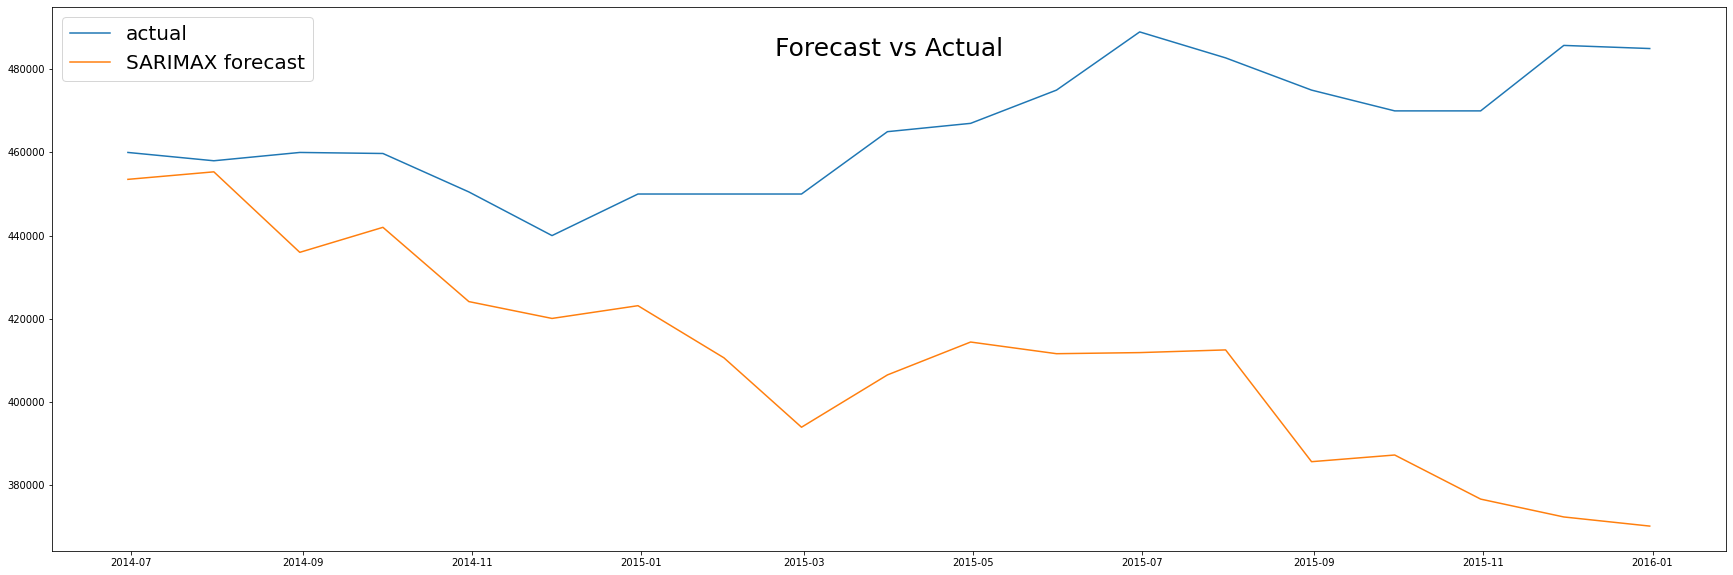

In [21]:
y_pred_series = pd.Series(y_pred_inv,index=val.index)
plt.figure(figsize=(30, 10))

plt.plot(val.MedianSoldPrice, label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show()

In [25]:
mape_val2=(np.abs(np.array(val.MedianSoldPrice)-np.array(y_pred_inv))/np.array(val.MedianSoldPrice)).mean()
print(f"MAPE of Multivariate: {mape_val2}")

MAPE of Multivariate: 0.11554518934299356


In [26]:
rmse2 = rmse_cal(np.array(val.MedianSoldPrice), np.array(y_pred_inv))
print(f"RMSE of Multivariate: {rmse2}")


RMSE of Multivariate: 64152.90553541888


In [27]:
#predicted values
y_pred_inv

array([453527.99213716, 455337.60639772, 435969.63021578, 441984.71549792,
       424118.72504395, 420067.87573169, 423134.23276816, 410600.24575595,
       393897.52325952, 406480.29393915, 414391.04658434, 411584.73408875,
       411848.22740292, 412495.12153244, 385604.7249713 , 387209.93889062,
       376603.84285595, 372306.8209938 , 370110.45440059])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6c37d8b-bf55-4e4d-a354-b401be14f3dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>